In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import SGate

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [82]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 2
numQubit = 2
global iterations
global noisy

In [86]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

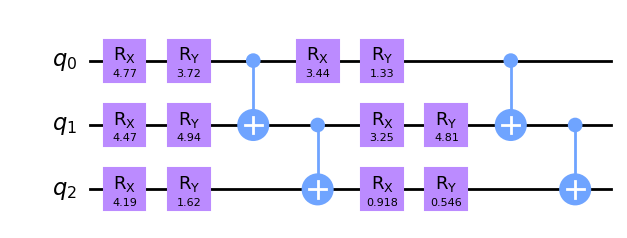

In [85]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 3
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [87]:
def createEqSuperposCollectiveZBSE():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [110]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix G from https://arxiv.org/pdf/2105.12758
    The ciruit contains 5 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(5)
    
    superPosCircuit = createEqSuperposCollectiveZBSE()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3, 4])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3, 4])
    
    controlledU1 = SGate().control(1)
    circ.append(controlledU1, [1, 2])
    circ.append(controlledU1, [1, 3])
    circ.append(controlledU1, [1, 4])
    
    circ.append(CZGate(), [0, 2])
    circ.append(CZGate(), [0, 3])
    circ.append(CZGate(), [0, 4])
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

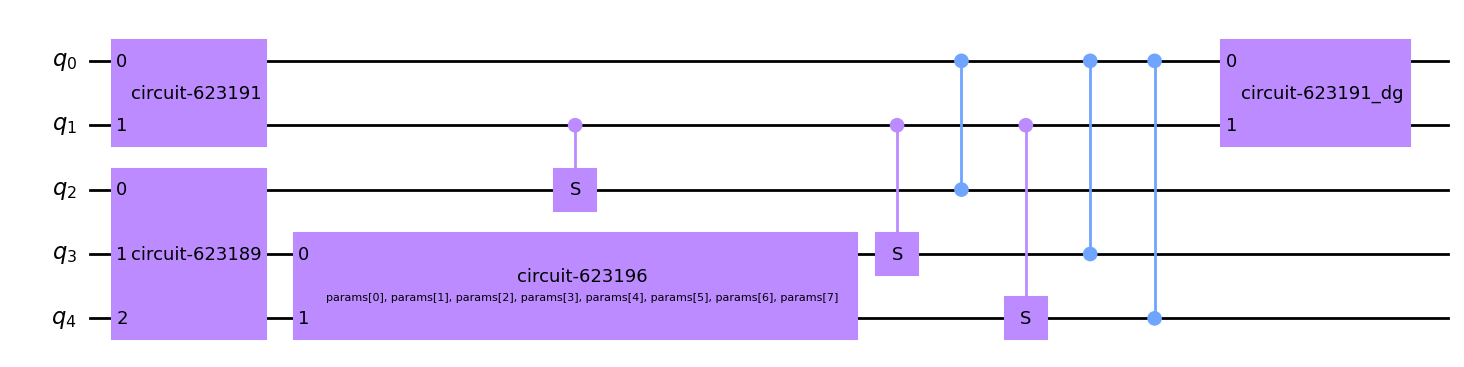

In [111]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [117]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7])])


In [112]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [113]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [115]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [116]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [118]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [114]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [119]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[1.30447038 5.75498337 0.24670804 5.79434989 3.65249744 4.18855704
 1.47547248 3.24773084]
Initial Cost :  0.19182044009066757


In [120]:
'''
True value calculated using the SDP.
'''
true_value = 0.7463150074114098

In [121]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.19182044009066757
Loss Value :  0.5765531549400122 1.0%
Loss Value :  0.5765002141178437 2.0%
Loss Value :  0.5013243838260423 3.0%
Loss Value :  0.5384962024431854 4.0%
Loss Value :  0.5395746842572676 5.0%
Loss Value :  0.6615943058700237 6.0%
Loss Value :  0.6652336818065622 7.0%
Loss Value :  0.6651571393632175 8.0%
Loss Value :  0.6662527410507475 9.0%
Loss Value :  0.7016423050661417 10.0%
Loss Value :  0.7215853449671435 11.0%
Loss Value :  0.7251123018319601 12.0%
Loss Value :  0.7251648411390573 13.0%
Loss Value :  0.7272642849783288 14.0%
Loss Value :  0.7283346504159421 15.0%
Loss Value :  0.7326354249126344 16.0%
Loss Value :  0.7334508365775471 17.0%
Loss Value :  0.7334007661097042 18.0%
Loss Value :  0.7334062940980451 19.0%
Loss Value :  0.7334401370450956 20.0%
Loss Value :  0.7343795850124534 21.0%
Loss Value :  0.7344379076776422 22.0%
Loss Value :  0.7343661197299186 23.0%
Loss Value :  0.7343968774175734 24.0%
Loss Value :  0.738697717322397 25.0%

In [122]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.19484073719064823
Loss Value :  0.1285610803433962 1.0%
Loss Value :  0.19509988883066368 2.0%
Loss Value :  0.23987265416330206 3.0%
Loss Value :  0.28099309326994815 4.0%
Loss Value :  0.28627558121504154 5.0%
Loss Value :  0.3731528290345001 6.0%
Loss Value :  0.3714491218677142 7.0%
Loss Value :  0.4103086190450866 8.0%
Loss Value :  0.4137240049307145 9.0%
Loss Value :  0.4175926501146412 10.0%
Loss Value :  0.41947162109305636 11.0%
Loss Value :  0.4303757412485613 12.0%
Loss Value :  0.4362804683506355 13.0%
Loss Value :  0.43954248166006354 14.0%
Loss Value :  0.48255606814859936 15.0%
Loss Value :  0.4807841140929428 16.0%
Loss Value :  0.51137233002837 17.0%
Loss Value :  0.5683572235727006 18.0%
Loss Value :  0.5952077597550394 19.0%
Loss Value :  0.6048110862488192 20.0%
Loss Value :  0.594943844127164 21.0%
Loss Value :  0.6306929593231846 22.0%
Loss Value :  0.6418474802019005 23.0%
Loss Value :  0.6582076489724816 24.0%
Loss Value :  0.6648560111252446 

In [123]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.7408891258900123


In [124]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.7463150074114098
Noiseless :  0.7414774465771125
Noisy :  0.7313701318309846
Noise Resilient Value :  0.7408891258900123


In [129]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("CZ_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [130]:
writeToFile()